## Travel Agent
- Agent 에 웹 검색, 날씨 정보 검색 등 LangGraph 에서 제공하는 Tool 추가

In [1]:
from dotenv import load_dotenv

# .env 파일의 환경변수를 기존 값과 상관없이 덮어쓰기
load_dotenv(override=True)

True

In [2]:
# 에이전트 실행 시 로깅을 활성화
import logging
logging.basicConfig(level=logging.INFO)

In [3]:
# Debug 모드로 실행할 경우 다음 주석 해제 후 실행
# from langchain.globals import set_debug
# set_debug(True)

In [4]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_search = TavilySearchResults(max_results=3)
# 웹 검색 도구 tavily의 이름과 설명을 설정합니다.
tavily_search.name = "tavily_search"
tavily_search.description = "Use this tool to search on the web using tavily"

/var/folders/j1/rm0gdwk50j339fwgq9nr34t40000gn/T/ipykernel_45948/850503822.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(max_results=3)


In [5]:
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain_core.tools import Tool

serper_search = Tool(
    name="serper_search",
    func=GoogleSerperAPIWrapper().run,
    description="Search with Serper"
)

In [6]:
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain_core.tools import Tool

serper_places = Tool(
        name="serper_places",
        func=GoogleSerperAPIWrapper(type="places").run,
        description="Use this tool to get information of the place",
    )

In [7]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

wikipedia_search = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

wikipedia_search.name = "wikipedia_search"
wikipedia_search.description = "Use this tool to search on the wikipedia"

In [8]:
from langchain_community.utilities import OpenWeatherMapAPIWrapper
from langchain_core.tools import Tool

weather_search = Tool(
    name="weather_search",
    func=OpenWeatherMapAPIWrapper().run,
    description="Use this tool to search the weather of a city or country"
)

/Users/judy/Documents/__GoToLearn_2기__/agent_project/travel-agent/.venv/lib/python3.12/site-packages/pyowm/commons/cityidregistry.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


In [9]:
from langchain_community.tools import YouTubeSearchTool

youtube_search = YouTubeSearchTool()

youtube_search.name = "youtube_search"
youtube_search.description = "Use this tool to search on the youtube"

In [10]:
tools = [
    # 웹 검색
    tavily_search,
    serper_search, 
    # Google places 정보 검색
    serper_places,
    # 위키피디아 검색
    wikipedia_search,
    # 날씨 검색
    weather_search,
    # 유튜브 검색
    youtube_search
    ]

In [11]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model='gpt-4o-mini',
    # max_tokens=128 # 테스트가 필요할 경우 token 수를 제한하여 비용을 절약할 수 있음
    )

In [12]:
from typing import TypedDict

class State(TypedDict):
    user_input: str
    plan: str
    cost: str

In [13]:
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import SystemMessage, HumanMessage

def planner_agent(state: State):
    print("🗺️ 여행 일정을 생성합니다.")
    planner = create_react_agent(
        llm, tools, prompt="당신은 여행 비서 어시스턴트입니다. 여행자의 기본정보를 참고하여, 질문에 정중하고 구체적으로 대답하세요."
    )

    system_prompt = """    
    여행 장소는 웹 검색 결과 최근 1년 이내의 정보를 이용해 선정합니다.
    여행자가 방문할 장소의 주소를 반드시 제공하고, 여행 정보를 제공해 주세요. 정보는 방문 가능 여부와 운영일 및 운영시간, 입장료, 홈페이지 등을 포함합니다.
    여행 장소는 하루에 최소 2개 이상 추천하고, 여행 일정은 방문 장소의 주소와 방문 가능 여부를 참고하여 최대한 이동 동선이 짧게 효율적으로 작성해 주세요.
    """

    response = planner.invoke({
        "messages": [
            SystemMessage(content=system_prompt),
            HumanMessage(content=state['user_input'])
        ]
    })

    state['plan'] = response["messages"][-1].content

    return state

In [14]:
def human_in_the_loop_agent(state: State):
    print("\n📝 생성된 여행 일정입니다:")
    print(state["plan"])
    decision = input("\n✅ 이 일정으로 확정할까요? (y/n): ")
    if decision.lower() == "y":
        return state
    else:
        state["plan"] = input("✏️ 일정을 직접 수정해 주세요")
    return state

In [19]:
def calc_agent(state: State):
    print("🧮 여행 비용을 계산합니다.")
    cost_agent = create_react_agent(
        llm,
        tools,
        prompt="당신은 여행 예산 계산 도우미입니다. 여행자의 정보와 여행 정보를 받아 인원수에 따른 총 비용 합계를 계산하세요."
    )

    system_prompt = """친구, 배우자 등 사용자 이외에 동행하는 여행자가 있는 경우 인원수를 추가하여 비용을 계산합니다.
        비용 정보가 존재하지 않는 경우 웹에서 검색합니다.
        비용은 현지 화폐 단위로 계산하고, 반드시 웹에서 현재 환율을 검색한 뒤 적용하여 한국 화폐로 환전한 비용도 함께 명시해 주세요."""

    response = cost_agent.invoke({
        "messages": [
            SystemMessage(content=system_prompt),
            HumanMessage(content="여행자 정보: " + state['user_input']),
            HumanMessage(content="비용을 포함한 여행 정보: " + state['plan']),
        ]
    })

    state["cost"] = response["messages"][-1].content

    return state

In [20]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(State)

workflow.add_node("Travel_Planner", planner_agent)
workflow.add_node("human_in_the_loop_agent", human_in_the_loop_agent)
workflow.add_node("calc_agent", calc_agent)

workflow.set_entry_point("Travel_Planner")
workflow.add_edge("Travel_Planner", "human_in_the_loop_agent")
workflow.add_edge("human_in_the_loop_agent", "calc_agent")
workflow.add_edge("calc_agent", END)

graph = workflow.compile()

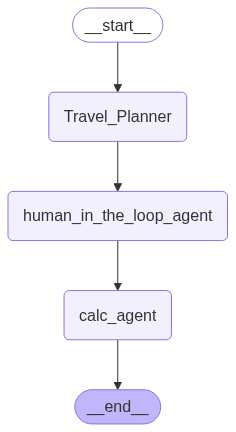

In [17]:
from IPython.display import Image, display
# Mermaid 시각화
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print("그래프 시각화 실패:", e)
    print(graph.get_graph().draw_mermaid())  # 소스코드 출력

In [21]:
user_input = "나는 프리다 칼로를 좋아해서 남편과 함께 멕시코를 여행할 예정이야. 6월 20일부터 24일 사이, 멕시코시티 위주로 일일 여행 코스를 추천해 줘."
response = graph.invoke({"user_input" : user_input})
print("✅ Travel-Agent 의 작업이 완료되었습니다.")

🗺️ 여행 일정을 생성합니다.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



📝 생성된 여행 일정입니다:
멕시코시티에서의 프리다 칼로를 테마로 한 여행 코스를 다음과 같이 제안드립니다. 6월 20일부터 24일 사이에 두 곳의 유명한 박물관을 포함하여, 효율적인 동선으로 계획하였습니다. 

### 여행 일정

#### 1일차: 프리다 칼로 박물관 (Casa Azul)
- **주소**: Calle Londres 247, Del Carmen, Coyoacán, 04100 Ciudad de México, CDMX, México
- **운영일 및 시간**: 화요일 - 수요일 11:00 - 18:00, 목요일 - 일요일 10:00 - 18:00 (월요일 휴무)
- **입장료**: 약 240MXN (약 10달러)
- **홈페이지**: [Frida Kahlo Museum](https://www.museofridakahlo.org.mx/)
- **내용**: 프리다 칼로와 디에고 리베라의 집이었던 이곳은 그들의 예술과 삶을 깊이 이해할 수 있는 장소입니다. 스와일지 필터와 화려한 정원은 특별한 경험을 제공합니다.

#### 2일차: 국립 인류학 박물관 (Museo Nacional de Antropología)
- **주소**: Av. Paseo de la Reforma y Calzada Gandhi s/n, Col. Chapultepec Polanco, Miguel Hidalgo, 11560 Ciudad de México, CDMX, México
- **운영일 및 시간**: 화요일 - 일요일 9:00 - 17:00 (월요일 휴무)
- **입장료**: 일반 입장 100MXN (무료 관람일: 화요일 - 토요일, 13세 이하 및 장애인 무료)
- **홈페이지**: [National Museum of Anthropology](https://www.mna.inah.gob.mx/)
- **내용**: 멕시코의 고대 문화를 탐험할 수 있는 이 박물관은 세계 최대의 고대 멕시코 예술 컬렉션을 보유하고 있습니다. 아즈텍 문명의 유물들과 역사적인 전시물들이 가득합니다.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


✅ Travel-Agent 의 작업이 완료되었습니다.


In [22]:
print(response['plan'])

멕시코시티에서의 프리다 칼로를 테마로 한 여행 코스를 다음과 같이 제안드립니다. 6월 20일부터 24일 사이에 두 곳의 유명한 박물관을 포함하여, 효율적인 동선으로 계획하였습니다. 

### 여행 일정

#### 1일차: 프리다 칼로 박물관 (Casa Azul)
- **주소**: Calle Londres 247, Del Carmen, Coyoacán, 04100 Ciudad de México, CDMX, México
- **운영일 및 시간**: 화요일 - 수요일 11:00 - 18:00, 목요일 - 일요일 10:00 - 18:00 (월요일 휴무)
- **입장료**: 약 240MXN (약 10달러)
- **홈페이지**: [Frida Kahlo Museum](https://www.museofridakahlo.org.mx/)
- **내용**: 프리다 칼로와 디에고 리베라의 집이었던 이곳은 그들의 예술과 삶을 깊이 이해할 수 있는 장소입니다. 스와일지 필터와 화려한 정원은 특별한 경험을 제공합니다.

#### 2일차: 국립 인류학 박물관 (Museo Nacional de Antropología)
- **주소**: Av. Paseo de la Reforma y Calzada Gandhi s/n, Col. Chapultepec Polanco, Miguel Hidalgo, 11560 Ciudad de México, CDMX, México
- **운영일 및 시간**: 화요일 - 일요일 9:00 - 17:00 (월요일 휴무)
- **입장료**: 일반 입장 100MXN (무료 관람일: 화요일 - 토요일, 13세 이하 및 장애인 무료)
- **홈페이지**: [National Museum of Anthropology](https://www.mna.inah.gob.mx/)
- **내용**: 멕시코의 고대 문화를 탐험할 수 있는 이 박물관은 세계 최대의 고대 멕시코 예술 컬렉션을 보유하고 있습니다. 아즈텍 문명의 유물들과 역사적인 전시물들이 가득합니다.

### 이동 팁
이 두 박물관

In [23]:
print(response['cost'])

멕시코시티에서의 프리다 칼로를 테마로 한 여행 비용을 계산해 보겠습니다. 여행 기간은 6월 20일부터 24일이며, 두 곳의 박물관에 대한 입장료와 현재 환율을 포함하여 총 비용을 산출하겠습니다.

### 여행 비용

1. **프리다 칼로 박물관 (Casa Azul)**:
   - **입장료**: 240 MXN (약 17,450 KRW)
   
2. **국립 인류학 박물관 (Museo Nacional de Antropología)**:
   - **입장료**: 100 MXN (약 7,250 KRW)

#### 총 비용 계산
- **총 입장료 (두 명)**:
  - 프리다 칼로 박물관: 240 MXN * 2인 = 480 MXN
  - 국립 인류학 박물관: 100 MXN * 2인 = 200 MXN
- **총 합계**: 480 + 200 = **680 MXN** 

#### 한화 환산
- **현재 환율**: 1 MXN = 72.51 KRW (현재 환율에 따라 변동할 수 있습니다)
  - 총 비용: 680 MXN * 72.51 KRW = **49,197.80 KRW** (약 49,200 원)

### 요약
- **총 여행 비용 (두 사람 기준)**: 약 49,200 원 (멕시코시티에서 프리다 칼로 박물관과 국립 인류학 박물관 포함)

추가로 숙박, 음식, 대중교통 등의 비용이 포함되지 않은 사항도 있으니 이를 고려하시기 바랍니다. 멋진 여행 되세요! 추가 질문이 있으시면 언제든지 문의 주세요.
